# plot_combined_error_mse_comparison

Interactive notebook for the Snakemake rule that plots combined per-parameter error histograms and standardized MSE in one figure.

## Imports & Environment
Load all required packages and set up autoreload for development.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add project root to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sfp_nsdsyn import utils
from sfp_nsdsyn import two_dimensional_model as model
from sfp_nsdsyn.bootstrapping import (
    calculate_error_per_param,
    calculate_null_error_per_param_distribution,
    calculate_standardized_metric_comparison
)
from sfp_nsdsyn.visualization import plot_2D_model_results as vis2D

## Define Wildcards and Parameters
Set wildcard values and constants. Use smaller `n_perm` for testing.

In [2]:
# Wildcards - use smaller n_perm for testing (change to 1000 for full run)
n_perm = 100  # For testing; set to 1000 for production
lr = 0.0005
max_epoch = 30000
vs = 'pRFsize'

# Constants from Snakefile
ARGS_2D = ['lr', 'eph', 'sub', 'roi']
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
OUTPUT_DIR = '/Volumes/server/Projects/sfp_nsd/derivatives/'

# Helper functions
def get_sn_list(dset):
    if dset == "broderick":
        return [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
    elif dset == "nsdsyn":
        return list(np.arange(1, 9))

def make_subj_list(dset):
    return [utils.sub_number_to_string(sn, dataset=dset) for sn in get_sn_list(dset)]

nsd_subj_list = make_subj_list('nsdsyn')
broderick_subj_list = make_subj_list('broderick')

nsd_subj_list, broderick_subj_list

(['subj01',
  'subj02',
  'subj03',
  'subj04',
  'subj05',
  'subj06',
  'subj07',
  'subj08'],
 ['wlsubj001',
  'wlsubj006',
  'wlsubj007',
  'wlsubj045',
  'wlsubj046',
  'wlsubj062',
  'wlsubj064',
  'wlsubj081',
  'wlsubj095',
  'wlsubj114',
  'wlsubj115',
  'wlsubj121'])

## Define Input Paths
Build file paths for NSD models, Broderick models, and null permutation models.

In [3]:
nsd_models = [
    os.path.join(OUTPUT_DIR, "sfp_model", "results_2D", "nsdsyn",
                 f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-V1_vs-{vs}.pt')
    for subj in nsd_subj_list
]

broderick_models = [
    os.path.join(OUTPUT_DIR, "sfp_model", "results_2D", "broderick",
                 f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-V1_vs-{vs}.pt')
    for subj in broderick_subj_list
]

null_nsd_models = [
    os.path.join(OUTPUT_DIR, "sfp_model", "results_2D", "nsdsyn", 'perm', subj,
                 f'perm-{perm}_model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-V1_vs-{vs}.pt')
    for perm in range(n_perm)
    for subj in nsd_subj_list
]

f"NSD models: {len(nsd_models)}, Broderick models: {len(broderick_models)}, Null models: {len(null_nsd_models)}"

'NSD models: 8, Broderick models: 12, Null models: 800'

## Define Output Paths
Set output file paths for PNG and SVG formats.

In [4]:
output_plot1 = os.path.join(OUTPUT_DIR, 'figures', 'sfp_model', 'results_2D', 'perm',
                            f'combined_error_mse_nsd-broderick_nperm-{n_perm}_lr-{lr}_eph-{max_epoch}_vs-{vs}.png')
output_plot2 = os.path.join(OUTPUT_DIR, 'figures', 'sfp_model', 'results_2D', 'perm',
                            f'combined_error_mse_nsd-broderick_nperm-{n_perm}_lr-{lr}_eph-{max_epoch}_vs-{vs}.svg')

output_plot1, output_plot2

('/Volumes/server/Projects/sfp_nsd/derivatives/figures/sfp_model/results_2D/perm/combined_error_mse_nsd-broderick_nperm-100_lr-0.0005_eph-30000_vs-pRFsize.png',
 '/Volumes/server/Projects/sfp_nsd/derivatives/figures/sfp_model/results_2D/perm/combined_error_mse_nsd-broderick_nperm-100_lr-0.0005_eph-30000_vs-pRFsize.svg')

## Load NSD and Broderick Models
Load fitted model parameters for both datasets.

In [5]:
nsd_df = model.load_all_models(nsd_models, *ARGS_2D)
broderick_df = model.load_all_models(broderick_models, *ARGS_2D)

nsd_df.head()

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,lr_rate,max_epoch,sub,vroinames
0,2.536201,0.139149,0.271883,-0.072822,0.003162,-0.255981,0.014144,0.080796,-0.015730,0.0005,30000,subj01,V1
0,1.938979,0.148039,0.082835,0.147832,-0.039300,-0.038702,-0.000303,0.030481,-0.002720,0.0005,30000,subj02,V1
0,2.352920,0.056186,0.105715,0.152566,-0.006781,0.065288,-0.066534,0.006534,-0.023752,0.0005,30000,subj03,V1
0,1.942852,0.206604,0.119989,0.133012,-0.023695,0.069233,-0.062159,0.076657,-0.018837,0.0005,30000,subj04,V1
0,2.365176,0.118251,0.130331,0.028012,-0.033951,-0.117134,-0.089555,0.038780,-0.013571,0.0005,30000,subj05,V1


In [6]:
broderick_df.head()

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,lr_rate,max_epoch,sub,vroinames
0,2.991311,0.070599,0.401411,0.011372,-0.023886,0.007266,0.001402,0.031317,-0.007021,0.0005,30000,wlsubj001,V1
0,2.210414,0.191500,0.319517,0.072905,-0.027447,0.036066,-0.007128,0.047671,0.007991,0.0005,30000,wlsubj006,V1
0,1.859804,0.123400,0.329031,0.060774,-0.059881,0.160479,-0.006987,0.033783,0.018614,0.0005,30000,wlsubj007,V1
0,1.840788,0.137035,0.193624,0.066284,-0.050465,0.016446,-0.014239,0.080737,-0.027840,0.0005,30000,wlsubj045,V1
0,2.235469,0.101706,0.222241,0.039933,-0.024075,0.083406,0.020845,0.038723,-0.012789,0.0005,30000,wlsubj046,V1


## Load Null Permutation Models
Load model parameters from permutation tests (shuffled labels).

In [7]:
null_nsd_df = model.load_all_models(null_nsd_models, *['sub', 'lr', 'eph', 'roi', 'perm'])
null_nsd_df['perm'] = null_nsd_df['perm'].astype(int)

null_nsd_df.head()

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,sub,lr_rate,max_epoch,vroinames,perm
0,8.344556,6.402747,6.478441,0.011790,-0.004045,-1.370019,0.834223,0.013898,-0.001160,subj01,0.0005,30000,V1,0
0,4.527784,0.612494,-0.174643,0.020044,-0.001698,-0.703148,0.718722,0.011895,0.004052,subj02,0.0005,30000,V1,0
0,4.740379,0.135906,0.299478,0.010406,0.003072,1.375295,0.791584,-0.007364,-0.001846,subj03,0.0005,30000,V1,0
0,4.795124,1.032707,-0.241707,-0.117397,-0.129154,-0.885448,0.413043,-0.013142,-0.024554,subj04,0.0005,30000,V1,0
0,10.175388,5.369055,6.361205,0.002037,0.004227,-1.390914,0.994338,-0.011198,-0.008207,subj05,0.0005,30000,V1,0


## Calculate Per-Parameter Errors
Compute squared error between NSD and Broderick means for each parameter.

In [8]:
actual_errors = calculate_error_per_param(nsd_df, reference=broderick_df, params=PARAMS_2D)
null_errors_df = calculate_null_error_per_param_distribution(null_nsd_df, broderick_df, params=PARAMS_2D)

actual_errors

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2
0,0.000805,0.000755,0.0451,0.000382,0.000002,0.011604,0.005536,0.000014,0.000192


In [9]:
null_errors_df.head()

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,perm
0,20.136095,7.159469,8.545467,0.008287,0.000326,0.624501,0.489031,0.001903,0.000014,0
1,46.005688,0.809838,5.977921,0.005869,0.000899,0.187886,0.035680,0.002029,0.000218,1
2,5.344580,0.001453,0.023333,0.000867,0.000187,0.043494,0.183334,0.002112,0.000062,2
3,6.705081,0.001222,0.080010,0.009844,0.003191,0.001065,0.190919,0.000957,0.000316,3
4,24.002604,1.766186,0.331608,0.031977,0.002937,0.787056,0.004980,0.003209,0.000145,4


## Calculate Standardized MSE
Compute MSE normalized by pooled standard deviation across parameters.

In [10]:
(actual_mse, actual_mae), null_result_list = calculate_standardized_metric_comparison(
    nsd_df, broderick_df, null_nsd_df, params=PARAMS_2D, metric='both'
)
null_mse_values = [d['mse'] for d in null_result_list]

f"Actual MSE: {actual_mse:.4e}, Actual MAE: {actual_mae:.4e}"

'Actual MSE: 6.8665e-01, Actual MAE: 9.6535e-01'

## Create Combined Plot
Generate (3x4) subplot figure with per-parameter error histograms and standardized MSE.

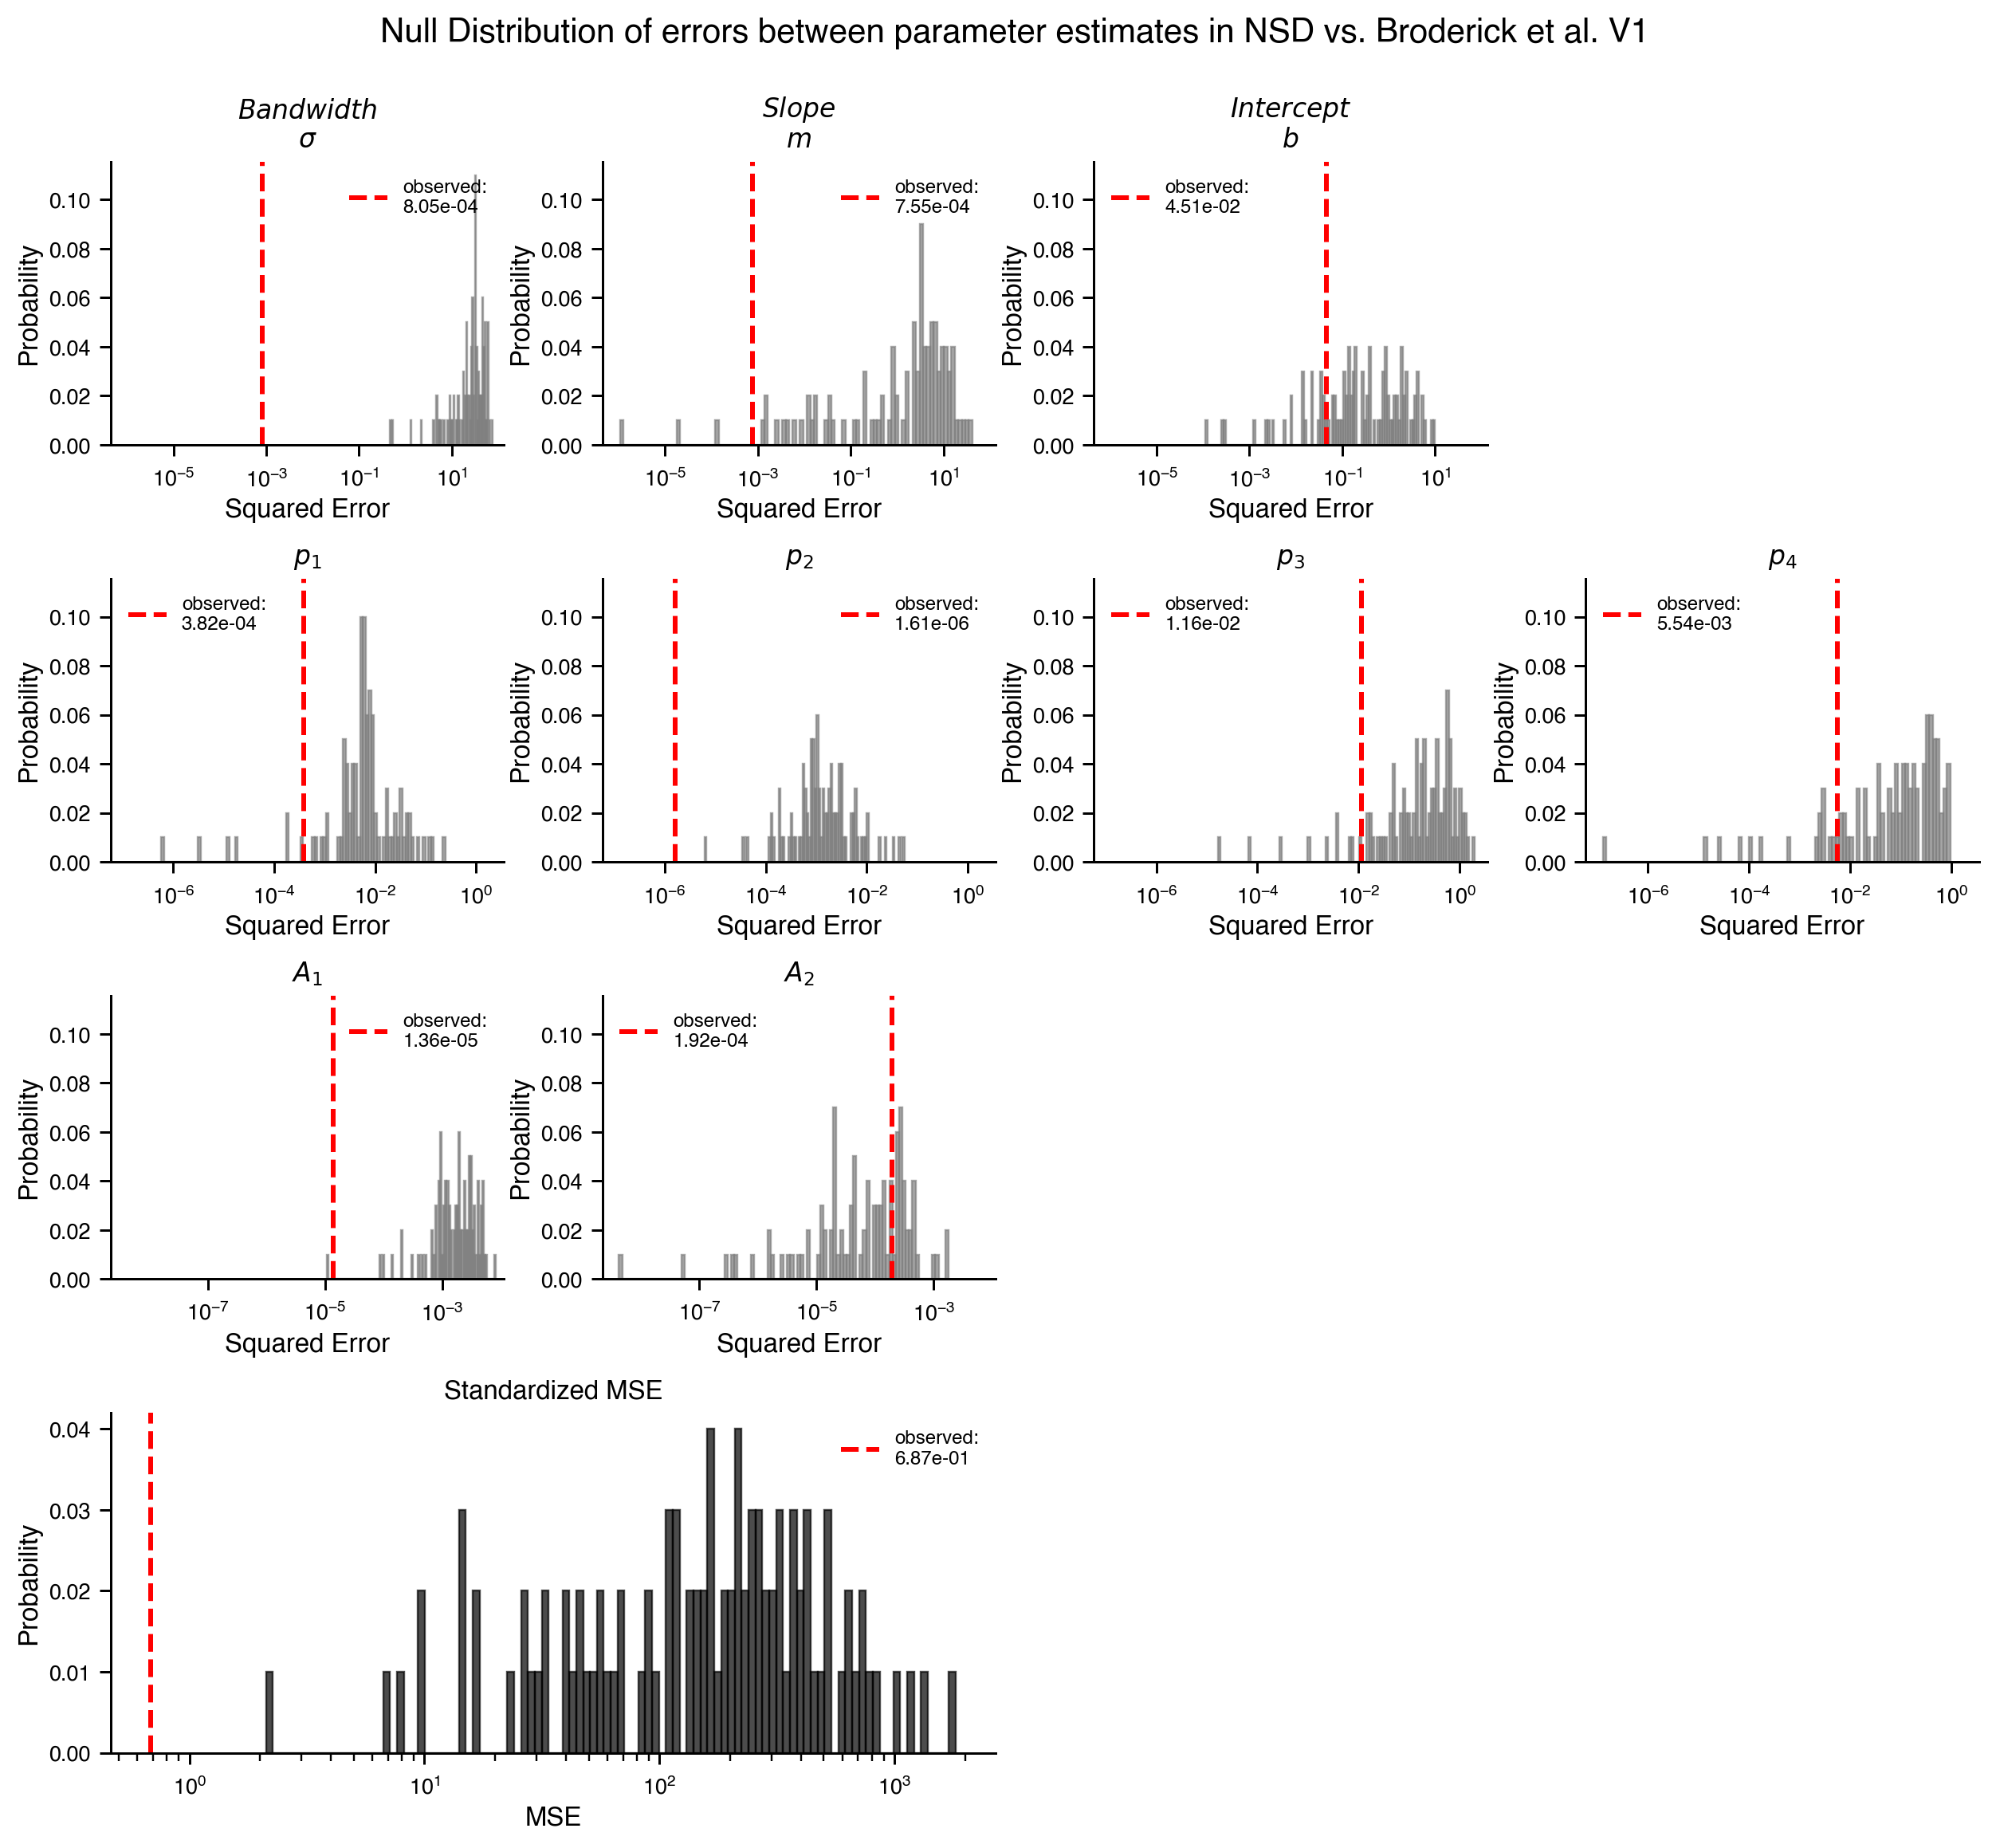

In [32]:
params_ordered = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'A_1', 'A_2', 'p_3', 'p_4']

fig, axes = vis2D.plot_combined_null_distributions(
    null_errors_df, actual_errors,
    null_mse_values, actual_mse,
    params=params_ordered,
    title=f'Null Distribution of errors between parameter estimates in NSD vs. Broderick et al. V1',
    bins=100,
    save_path=None  # Don't save, just display
)

Figure X. Null distributions of parameter-wise squared errors and standardized mean squared error (MSE) between NSD and Broderick et al. V1 parameter estimates. To assess whether NSD parameter estimates are statistically consistent with those from Broderick et al., we constructed null distributions by permuting subject labels across datasets. For each of 100 permutations, we randomly reassigned subject identities between NSD and Broderick datasets and recomputed the squared difference between group means for each parameter. (A) Per-parameter null distributions. Each histogram shows the distribution of squared errors under the null hypothesis for one of nine 2D spatial frequency model parameters: bandwidth ($\sigma$), slope ($m$) and intercept ($b$) of the preferred spatial frequency–eccentricity relationship, phase preferences ($p_1$–$p_4$), and amplitude modulations ($A_1$, $A_2$). Gray bars represent the null distribution; bar heights indicate probability (counts normalized to sum to 1). The x-axis uses a logarithmic scale with log-spaced bins (100 bins spanning the range of positive values via geometric spacing). The red dashed vertical line marks the observed squared error computed from the actual (unpermuted) group means, with the numeric value displayed in the legend. Within each row, subplots share the same x-axis limits to facilitate comparison of error magnitudes across parameters with similar scales. All subplots share a common y-axis to enable direct comparison of distribution shapes. (B) Standardized MSE null distribution. To obtain a single summary statistic, we computed the standardized MSE: for each parameter, the squared error was divided by the pooled variance across both datasets, then averaged across all nine parameters. Light blue bars show the null distribution of this standardized MSE. The red dashed line indicates the observed standardized MSE (6.87 × 10⁻¹). When the observed value falls within the bulk of the null distribution, this indicates that differences between NSD and Broderick et al. parameter estimates are consistent with sampling variability; observed values in the extreme tails would suggest systematic differences between datasets.

## Save Plots (Optional)
Uncomment to save PNG and SVG versions.

In [12]:
# Uncomment to save
# fig.savefig(output_plot1, dpi=300, bbox_inches='tight')
# fig.savefig(output_plot2, bbox_inches='tight')